# Dataset Selection and information

I chose to work with the **Bank Marketing dataset** from the UCI Machine Learning Repository.

- **Dataset link**: [https://archive.ics.uci.edu/dataset/222/bank+marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
- **Instances**: 41,188
- **Features**: 20 (client demographics, campaign history, and contact attributes)
- **Target**: Binary classification  
  - `yes` = client subscribed to a term deposit  
  - `no` = client did not subscribe


## Data Preprocessing 

> Note: I have my own data preprocessing checklist which I used to guide data preprocessing.

### Peak data to view structure and catagories

In [81]:
import pandas as pd

# Load the dataset 
# Note this data is semicolon sepperated
df = pd.read_csv('../data/raw/bank-additional-full.csv', sep=';')

# Peak the data so we can get an idea of how it looks
print(f"Shape: {df.shape}")
df.head()

# Check data types and nulls
df.info()
df.isnull().sum()

Shape: (41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.id

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Target Converting and Class balance 

In [38]:
# Convert target variable to binary classification
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Show updated class balance
print("Class distribution:")
print(df['y'].value_counts(normalize=True).round(3))

Class distribution:
y
0    0.887
1    0.113
Name: proportion, dtype: float64


### Encode Categorical and Normalize Numerical Data

In [39]:
from sklearn.preprocessing import StandardScaler

# Identify categorical and numeric features
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('y')

# One hot encode categoricals
# We want to drop the first column to ensure we dont have perfectly correleated columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # See reference [2]

# Standardize numeric columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

### Split and Save Data

In [40]:
from sklearn.model_selection import train_test_split

# Split features and target
X = df.drop('y', axis=1)
y = df['y']

# 98% train+val, 2% test splits
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.02, stratify=y, random_state=42)

# Save
X_trainval.to_csv('../data/cleaned/X_trainval.csv', index=False)
y_trainval.to_csv('../data/cleaned/y_trainval.csv', index=False)
X_test.to_csv('../data/cleaned/X_test.csv', index=False)
y_test.to_csv('../data/cleaned/y_test.csv', index=False)

# Nerual Net Manual Implementation

In [50]:
# Imports
import numpy as np

# Class to make simple 1 layer neural network 
class NeuralNetwork:
    # Initialize network structure 
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, seed=42):
        np.random.seed(seed)  
        self.learning_rate = learning_rate

        # Elected to use scaled random normal weight initalization (See reference [3])
        # Initialize weights and biases for hidden layer
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))

        # Initialize weights and biases for output layer
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    # Sigmoid activation
    def sigmoid(self, z):
        z = np.array(z, dtype=np.float64)  # Force z to be a compatable type solution from here: https://stackoverflow.com/questions/18557337/numpy-attributeerror-float-object-has-no-attribute-exp
        return 1 / (1 + np.exp(-z))

    # Derivative of sigmoid
    def sigmoid_derivative(self, a):
        return a * (1 - a)

    # Forward propagation
    def forward_propagation(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1 # input to hidden layer
        self.A1 = self.sigmoid(self.Z1) # activation of hidden layer
        self.Z2 = np.dot(self.A1, self.W2) + self.b2 # input to output layer
        self.A2 = self.sigmoid(self.Z2) # final prediction
        return self.A2

    # Compute binary cross entropy cost (This equation was derived in HIGGS linear classifiers)
    def compute_cost(self, Y_hat, Y):
        m = Y.shape[0]  # number of samples
        cost = -np.mean(Y * np.log(Y_hat + 1e-8) + (1 - Y) * np.log(1 - Y_hat + 1e-8))
        return cost

    # Backward propagation 
    def backward_propagation(self, X, Y, Y_hat):
        m = X.shape[0]

        # Gradient for output layer
        dZ2 = Y_hat - Y
        dW2 = (1 / m) * np.dot(self.A1.T, dZ2)
        db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True) # Note that we need keepdims here so the result keeps its (1 x output size) shape for compatibility with the bias

        # Gradient for hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid_derivative(self.A1)
        dW1 = (1 / m) * np.dot(X.T, dZ1)
        db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)

        # Update weights and biases VIA gradient descent
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    # Training loop
    def train(self, X, Y, epochs=1000):
        for i in range(epochs):
            Y_hat = self.forward_propagation(X)
            cost = self.compute_cost(Y_hat, Y) 
            self.backward_propagation(X, Y, Y_hat)

    # Predict class labels from input
    def predict(self, X, threshold = 0.5):
        Y_hat = self.forward_propagation(X)
        return (Y_hat > threshold).astype(int) # Return array as same shape as Y_hat but with 1 for > treshold and 0 for < treshold


## Training Model

In [71]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load training/validation data
X_trainval = pd.read_csv('../data/cleaned/X_trainval.csv').astype(np.float64).values
y_trainval = pd.read_csv('../data/cleaned/y_trainval.csv').astype(np.float64).values.reshape(-1, 1)

# Determine input size
input_size = X_trainval.shape[1]

# Initialize and train neural network
nn = NeuralNetwork(input_size=input_size, hidden_size=16, output_size=1, learning_rate=0.1)
nn.train(X_trainval, y_trainval, epochs=1000)

# Predict on training data
y_trainval_pred = nn.predict(X_trainval)

# Evaluate metrics
accuracy = accuracy_score(y_trainval, y_trainval_pred)
precision = precision_score(y_trainval, y_trainval_pred)
recall = recall_score(y_trainval, y_trainval_pred)
f1 = f1_score(y_trainval, y_trainval_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9052
Precision: 0.7009
Recall: 0.2762
F1 Score: 0.3963


### Evaluation

As we can see here the recall is very low which indicates the model is missing many true positives (This is expected with our inbalenced data set).     
Lets see if we can tune some hyperparameters to increase our preformance.

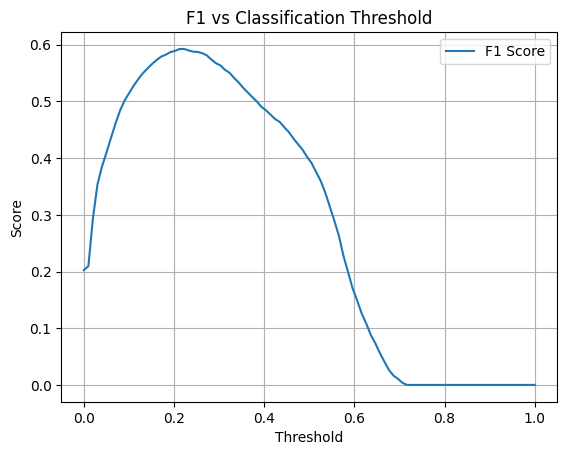

Best F1 Score: 0.5926 at Threshold: 0.22


In [73]:
# This idea was adapted from reference [4]
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict probabilities
Y_probs = nn.forward_propagation(X_trainval)

# Range of thresholds to test
thresholds = np.linspace(0.0, 1.0, 100)

# Store scores for each threshold
f1s = []

for t in thresholds:
    preds = (Y_probs > t).astype(int)
    f1s.append(f1_score(y_trainval, preds, zero_division=0))

# Plot F1 vs threshold
plt.plot(thresholds, f1s, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("F1 vs Classification Threshold")
plt.legend()
plt.grid(True)
plt.show()

best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Best F1 Score: {f1s[best_idx]:.4f} at Threshold: {best_threshold:.2f}")


## Retrain 

Now that we have a better threshold then our default 0.5, we will retrian and evaluate on a threshold of 0.22.

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load training/validation data
X_trainval = pd.read_csv('../data/cleaned/X_trainval.csv').astype(np.float64).values
y_trainval = pd.read_csv('../data/cleaned/y_trainval.csv').astype(np.float64).values.reshape(-1, 1)

# Determine input size
input_size = X_trainval.shape[1]

# Initialize and train neural network
nn = NeuralNetwork(input_size=input_size, hidden_size=16, output_size=1, learning_rate=0.1)
nn.train(X_trainval, y_trainval, epochs=1000)

# Predict on training data
y_trainval_pred = nn.predict(X_trainval, threshold = 0.22)

# Evaluate 
accuracy = accuracy_score(y_trainval, y_trainval_pred)
precision = precision_score(y_trainval, y_trainval_pred)
recall = recall_score(y_trainval, y_trainval_pred)
f1 = f1_score(y_trainval, y_trainval_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8926
Precision: 0.5173
Recall: 0.6932
F1 Score: 0.5925


## Testing

With a better recall lets test this on our sperate unseen test data 

Accuracy: 0.8968
Precision: 0.5351
Recall: 0.6559
F1 Score: 0.5894


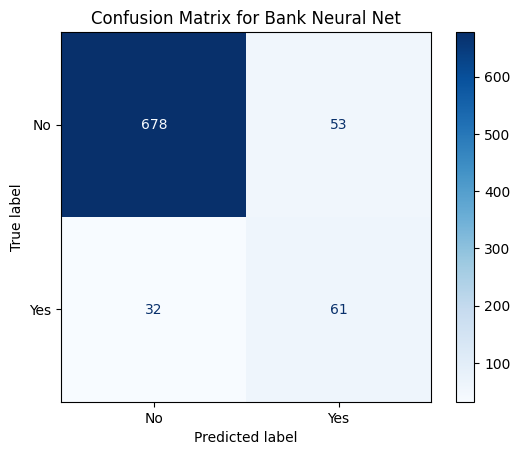

In [80]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load test data
X_test = pd.read_csv('../data/cleaned/X_test.csv').astype(np.float64).values
y_test = pd.read_csv('../data/cleaned/y_test.csv').astype(np.float64).values.reshape(-1, 1)

# Predict using threshold found in previous testing
y_test_pred = nn.predict(X_test, threshold=0.22)

# Evaluate 
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Bank Neural Net")
plt.show()


# Neural Network PyTorch Implementation

## Research into Pytorch Neural Networks

| Reference | Why I Used It |
|-----------|---------------|
| 5. https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html | Helped me understand how to define a neural network using `nn.Module`, structure layers, and implement the forward pass. |
| 6. https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html | Explained how PyTorch automatically handles backpropagation using `autograd`, replacing manual gradient calculations. |
| 7. https://pytorch.org/docs/stable/nn.html | Essential reference for understanding how to use layers, activation functions, loss functions, and optimizers. |


## References

1. Moro, S., Cortez, P., & Rita, P. (2014). *A data-driven approach to predict the success of bank telemarketing*. Decision Support Systems, 62, 22–31.  
   Retrieved from https://archive.ics.uci.edu/dataset/222/bank+marketing

2. GeeksforGeeks. (n.d.). *One-hot encoding in machine learning*.  
   Retrieved from https://www.geeksforgeeks.org/machine-learning/ml-one-hot-encoding/

3. GeeksforGeeks. (n.d.). *Weight Initialization Techniques for Deep Neural Networks*.  
Retrieved from https://www.geeksforgeeks.org/machine-learning/weight-initialization-techniques-for-deep-neural-networks/

4. GeeksforGeeks. (n.d.). *Handling Imbalanced Data for Classification*.  
    Retrieved from https://www.geeksforgeeks.org/machine-learning/handling-imbalanced-data-for-classification/

5. PyTorch. (n.d.). *Neural Networks Tutorial*.  
   Retrieved from https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

6. PyTorch. (n.d.). *Autograd Tutorial*.  
   Retrieved from https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

7. PyTorch. (n.d.). *torch.nn — Modules Documentation*.  
   Retrieved from https://pytorch.org/docs/stable/nn.html
